In [4]:
%pip install pandas nltk
# Run this in a code cell
%pip uninstall -y torch torchvision torchaudio

# Install the Nightly version (Required for RTX 5090)
%pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128


Note: you may need to restart the kernel to use updated packages.
Found existing installation: torch 2.11.0.dev20251228+cu128
Uninstalling torch-2.11.0.dev20251228+cu128:
  Successfully uninstalled torch-2.11.0.dev20251228+cu128
Found existing installation: torchvision 0.25.0.dev20251229+cu128
Uninstalling torchvision-0.25.0.dev20251229+cu128:
  Successfully uninstalled torchvision-0.25.0.dev20251229+cu128
Found existing installation: torchaudio 2.10.0.dev20251229+cu128
Uninstalling torchaudio-2.10.0.dev20251229+cu128:
  Successfully uninstalled torchaudio-2.10.0.dev20251229+cu128
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/nightly/cu128
   ━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.5/916.8 MB 7.2 MB/s eta 0:01:46
ERROR: Operation cancelled by user
^C
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/peridot

In [6]:
# Part 1: Imports and Setup
import json
import numpy as np
import pandas as pd
import re
from collections import Counter
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# NLP
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

# Download required NLTK data
nltk.download('punkt')
nltk.download("punkt_tab")
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


[nltk_data] Downloading package punkt to /home/peridot/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/peridot/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/peridot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/peridot/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [11]:
# Part 2: Load and preprocess news data
def load_news_data(json_path):
    """Load news articles from JSON file"""
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def clean_text(text):
    """Clean and normalize text"""
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove special characters but keep sentence structure
    text = re.sub(r'[^\w\s.,!?;:\-\']', '', text)
    return text.strip()

def chunk_article(content, chunk_size=300, overlap=50):
    """
    Split article into overlapping chunks (passages)
    chunk_size: target number of tokens per chunk
    overlap: number of tokens to overlap between chunks
    """
    words = content.split()
    chunks = []
    
    if len(words) <= chunk_size:
        return [content]
    
    start = 0
    while start < len(words):
        end = start + chunk_size
        chunk = ' '.join(words[start:end])
        chunks.append(chunk)
        start += (chunk_size - overlap)
        
        if end >= len(words):
            break
    
    return chunks

# Load your data
news_data = load_news_data('news.json')
print(f"Loaded {len(news_data)} articles")

# Process articles into passages
passages = []
passage_metadata = []

for idx, article in enumerate(tqdm(news_data, desc="Processing articles")):
    title = article.get('title', '')
    content = article.get('content', '')
    timestamp = article.get('timestamp', '')
    
    # Clean text
    clean_content = clean_text(content)
    
    # Create chunks
    chunks = chunk_article(clean_content)
    
    for chunk_idx, chunk in enumerate(chunks):
        passages.append({
            'text': chunk,
            'title': title,
            'timestamp': timestamp,
            'article_idx': idx,
            'chunk_idx': chunk_idx,
            'full_content': clean_content
        })
        
        passage_metadata.append({
            'passage_id': len(passages) - 1,
            'article_idx': idx,
            'title': title,
            'timestamp': timestamp
        })

print(f"Created {len(passages)} passages from {len(news_data)} articles")

# Create DataFrame for easier manipulation
passages_df = pd.DataFrame(passages)
print("\nPassage DataFrame shape:", passages_df.shape)
print("\nSample passage:")
print(passages_df.iloc[0])

Loaded 4430 articles


Processing articles: 100%|██████████| 4430/4430 [00:00<00:00, 20088.55it/s]

Created 5504 passages from 4430 articles

Passage DataFrame shape: (5504, 6)

Sample passage:
text            The Government of Nepal has declared a public ...
title           NEPSE to Remain Closed on Thursday, Govt Decla...
timestamp                               Thu, Sep 19, 2024 7:06 AM
article_idx                                                     0
chunk_idx                                                       0
full_content    The Government of Nepal has declared a public ...
Name: 0, dtype: object


In [12]:
# Part 3: Generate training questions from articles
def generate_training_questions(articles, num_questions_per_article=3):
    """
    Generate training questions from article titles and content
    """
    training_data = []
    
    for idx, article in enumerate(tqdm(articles, desc="Generating questions")):
        title = article.get('title', '')
        content = article.get('content', '')
        
        # Question 1: Title-based (What is discussed in this article?)
        q1 = {
            'question': f"What is discussed about {title.split(':')[0].split(',')[0]}?",
            'article_idx': idx,
            'answer': content[:200],  # First 200 chars as answer
            'answer_start': 0
        }
        training_data.append(q1)
        
        # Question 2: Extract key entities (Who/What mentioned?)
        sentences = sent_tokenize(content)
        if len(sentences) > 0:
            first_sent = sentences[0]
            # Simple entity extraction (you can improve this)
            words = first_sent.split()
            if len(words) > 3:
                q2 = {
                    'question': f"What happened according to the article titled '{title[:50]}'?",
                    'article_idx': idx,
                    'answer': first_sent,
                    'answer_start': content.find(first_sent)
                }
                training_data.append(q2)
        
        # Question 3: Date/Time based if timestamp exists
        if article.get('timestamp'):
            q3 = {
                'question': f"When was the article about {title.split()[0]} published?",
                'article_idx': idx,
                'answer': article.get('timestamp', ''),
                'answer_start': -1  # Special marker for metadata
            }
            training_data.append(q3)
    
    return training_data

# Generate training questions
training_questions = generate_training_questions(news_data)
print(f"Generated {len(training_questions)} training questions")

# Display sample questions
print("\nSample training questions:")
for i in range(min(3, len(training_questions))):
    print(f"\nQ{i+1}: {training_questions[i]['question']}")
    print(f"A: {training_questions[i]['answer'][:100]}...")

Generating questions: 100%|██████████| 4430/4430 [00:00<00:00, 12042.32it/s]

Generated 13258 training questions

Sample training questions:

Q1: What is discussed about NEPSE to Remain Closed on Thursday?
A: The Government of Nepal has declared a public holiday for today, Thursday (Ashwin 3), in celebration...

Q2: What happened according to the article titled 'NEPSE to Remain Closed on Thursday, Govt Declares '?
A: The Government of Nepal has declared a public holiday for today, Thursday (Ashwin 3), in celebration...

Q3: When was the article about NEPSE published?
A: Thu, Sep 19, 2024 7:06 AM...


In [13]:
# Part 4: Build vocabulary and prepare embeddings
class Vocabulary:
    def __init__(self):
        self.word2idx = {'<PAD>': 0, '<UNK>': 1, '<SOS>': 2, '<EOS>': 3}
        self.idx2word = {0: '<PAD>', 1: '<UNK>', 2: '<SOS>', 3: '<EOS>'}
        self.word_counts = Counter()
        self.n_words = 4
    
    def add_sentence(self, sentence):
        for word in word_tokenize(sentence.lower()):
            self.add_word(word)
    
    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.n_words
            self.idx2word[self.n_words] = word
            self.n_words += 1
        self.word_counts[word] += 1
    
    def trim(self, min_count=2):
        """Remove words below min_count"""
        keep_words = [word for word, count in self.word_counts.items() 
                     if count >= min_count]
        
        self.word2idx = {'<PAD>': 0, '<UNK>': 1, '<SOS>': 2, '<EOS>': 3}
        self.idx2word = {0: '<PAD>', 1: '<UNK>', 2: '<SOS>', 3: '<EOS>'}
        self.n_words = 4
        
        for word in keep_words:
            self.word2idx[word] = self.n_words
            self.idx2word[self.n_words] = word
            self.n_words += 1

# Build vocabulary
vocab = Vocabulary()

# Add passages to vocabulary
for passage in tqdm(passages, desc="Building vocabulary"):
    vocab.add_sentence(passage['text'])

# Add questions to vocabulary
for q in training_questions:
    vocab.add_sentence(q['question'])
    vocab.add_sentence(str(q['answer']))

print(f"Vocabulary size before trimming: {vocab.n_words}")
vocab.trim(min_count=2)
print(f"Vocabulary size after trimming: {vocab.n_words}")

# Save vocabulary
with open('vocabulary.pkl', 'wb') as f:
    pickle.dump(vocab, f)
print("Vocabulary saved to vocabulary.pkl")

Building vocabulary: 100%|██████████| 5504/5504 [00:02<00:00, 2255.58it/s]


Vocabulary size before trimming: 43925
Vocabulary size after trimming: 25552
Vocabulary saved to vocabulary.pkl


In [14]:
# Part 5: Initialize word embeddings
EMBEDDING_DIM = 100

def initialize_embeddings(vocab_size, embedding_dim):
    """Initialize random embeddings (you can replace with GloVe/fastText)"""
    embeddings = np.random.uniform(-0.1, 0.1, (vocab_size, embedding_dim))
    # PAD token should be zero
    embeddings[0] = np.zeros(embedding_dim)
    return torch.FloatTensor(embeddings)

# Create embedding matrix
embedding_matrix = initialize_embeddings(vocab.n_words, EMBEDDING_DIM)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

# Optional: Load GloVe embeddings if you have them
# You can download GloVe from: https://nlp.stanford.edu/projects/glove/
# And load them here to replace random embeddings

def load_glove_embeddings(glove_path, vocab, embedding_dim):
    """
    Load pre-trained GloVe embeddings (optional)
    Download from: https://nlp.stanford.edu/projects/glove/
    """
    embeddings = np.random.uniform(-0.1, 0.1, (vocab.n_words, embedding_dim))
    embeddings[0] = np.zeros(embedding_dim)  # PAD
    
    found = 0
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe"):
            values = line.split()
            word = values[0]
            if word in vocab.word2idx:
                vector = np.asarray(values[1:], dtype='float32')
                embeddings[vocab.word2idx[word]] = vector
                found += 1
    
    print(f"Found {found}/{vocab.n_words} words in GloVe")
    return torch.FloatTensor(embeddings)
print("If you have GloVe embeddings, you can load them using the function provided.")
# If you have GloVe, uncomment and use:
# embedding_matrix = load_glove_embeddings('glove.6B.100d.txt', vocab, EMBEDDING_DIM)

Embedding matrix shape: torch.Size([25552, 100])
If you have GloVe embeddings, you can load them using the function provided.


In [15]:
# Part 6: BiLSTM Retriever Model (FIXED for CPU/CUDA compatibility)

import torch
import torch.nn as nn
import torch.nn.functional as F

# Check CUDA availability and set device properly
if torch.cuda.is_available():
    try:
        # Test if CUDA actually works
        test_tensor = torch.zeros(1).cuda()
        device = torch.device('cuda')
        print(f"✓ Using CUDA device: {torch.cuda.get_device_name(0)}")
    except:
        print("⚠ CUDA available but not working, falling back to CPU")
        device = torch.device('cpu')
else:
    device = torch.device('cpu')
    print("Using CPU device")

class BiLSTMEncoder(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, num_layers=2, dropout=0.3):
        super(BiLSTMEncoder, self).__init__()
        
        vocab_size, embedding_dim = embedding_matrix.shape
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight = nn.Parameter(embedding_matrix)
        self.embedding.weight.requires_grad = True  # Fine-tune embeddings
        
        # BiLSTM
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Attention pooling
        self.attention = nn.Linear(hidden_dim * 2, 1)
        
        # Output projection
        self.output_dim = hidden_dim * 2
        
    def forward(self, input_ids, lengths):
        """
        Args:
            input_ids: (batch_size, seq_len)
            lengths: (batch_size,) actual lengths before padding
        Returns:
            encoded: (batch_size, hidden_dim * 2) fixed-size vectors
        """
        batch_size, seq_len = input_ids.shape
        
        # Embedding
        embedded = self.embedding(input_ids)  # (batch_size, seq_len, embedding_dim)
        
        # Ensure lengths are on CPU for pack_padded_sequence
        if lengths.is_cuda:
            lengths_cpu = lengths.cpu()
        else:
            lengths_cpu = lengths
        
        # Pack padded sequence
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths_cpu, batch_first=True, enforce_sorted=False
        )
        
        # BiLSTM
        lstm_out, (hidden, cell) = self.lstm(packed)
        
        # Unpack
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        # lstm_out: (batch_size, seq_len, hidden_dim * 2)
        
        # Attention pooling
        attention_scores = self.attention(lstm_out)  # (batch_size, seq_len, 1)
        attention_scores = attention_scores.squeeze(-1)  # (batch_size, seq_len)
        
        # Mask padding
        mask = torch.arange(seq_len, device=input_ids.device).unsqueeze(0) < lengths.unsqueeze(1)
        attention_scores = attention_scores.masked_fill(~mask, -1e9)
        
        # Softmax
        attention_weights = F.softmax(attention_scores, dim=1)  # (batch_size, seq_len)
        
        # Weighted sum
        encoded = torch.bmm(attention_weights.unsqueeze(1), lstm_out)  # (batch_size, 1, hidden_dim * 2)
        encoded = encoded.squeeze(1)  # (batch_size, hidden_dim * 2)
        
        return encoded

# Initialize retriever model - DON'T move to device yet, create on CPU first
retriever_model = BiLSTMEncoder(embedding_matrix, hidden_dim=128, num_layers=2)

# Now try to move to device
try:
    retriever_model = retriever_model.to(device)
    print(f"✓ Retriever model successfully moved to {device}")
except Exception as e:
    print(f"⚠ Could not move to {device}, using CPU instead")
    device = torch.device('cpu')
    retriever_model = retriever_model.to(device)

print(f"Retriever model created with output dim: {retriever_model.output_dim}")
print(f"Total parameters: {sum(p.numel() for p in retriever_model.parameters()):,}")
print(f"Device being used: {device}")

✓ Using CUDA device: NVIDIA GeForce RTX 5090
⚠ Could not move to cuda, using CPU instead
Retriever model created with output dim: 256
Total parameters: 3,186,241
Device being used: cpu


In [22]:
# Part 7: Retriever Training Setup

class RetrieverDataset(Dataset):
    def __init__(self, questions, passages, vocab, max_len=100):
        self.questions = questions
        self.passages = passages
        self.vocab = vocab
        self.max_len = max_len
        
    def text_to_indices(self, text):
        """Convert text to word indices"""
        tokens = word_tokenize(text.lower())
        indices = [self.vocab.word2idx.get(token, self.vocab.word2idx['<UNK>']) 
                  for token in tokens[:self.max_len]]
        length = len(indices)
        return indices, length
    
    def __len__(self):
        return len(self.questions)
    
    def __getitem__(self, idx):
        question = self.questions[idx]['question']
        article_idx = self.questions[idx]['article_idx']
        
        # Get positive passage (from same article)
        positive_passages = [p for p in self.passages if p['article_idx'] == article_idx]
        if len(positive_passages) == 0:
            positive_passages = [self.passages[0]]  # Fallback
        positive_passage = np.random.choice(positive_passages)
        
        # Get negative passage (from different article)
        negative_passages = [p for p in self.passages if p['article_idx'] != article_idx]
        if len(negative_passages) == 0:
            negative_passages = [self.passages[1]]  # Fallback
        negative_passage = np.random.choice(negative_passages)
        
        # Convert to indices
        q_indices, q_len = self.text_to_indices(question)
        pos_indices, pos_len = self.text_to_indices(positive_passage['text'])
        neg_indices, neg_len = self.text_to_indices(negative_passage['text'])
        
        return {
            'question': q_indices,
            'q_len': q_len,
            'positive': pos_indices,
            'pos_len': pos_len,
            'negative': neg_indices,
            'neg_len': neg_len
        }

def collate_fn(batch):
    """Custom collate function for DataLoader"""
    questions = [item['question'] for item in batch]
    positives = [item['positive'] for item in batch]
    negatives = [item['negative'] for item in batch]
    
    q_lens = torch.LongTensor([item['q_len'] for item in batch])
    pos_lens = torch.LongTensor([item['pos_len'] for item in batch])
    neg_lens = torch.LongTensor([item['neg_len'] for item in batch])
    
    # Pad sequences
    max_q_len = max(len(q) for q in questions)
    max_pos_len = max(len(p) for p in positives)
    max_neg_len = max(len(n) for n in negatives)
    
    q_padded = torch.zeros(len(batch), max_q_len, dtype=torch.long)
    pos_padded = torch.zeros(len(batch), max_pos_len, dtype=torch.long)
    neg_padded = torch.zeros(len(batch), max_neg_len, dtype=torch.long)
    
    for i, (q, p, n) in enumerate(zip(questions, positives, negatives)):
        q_padded[i, :len(q)] = torch.LongTensor(q)
        pos_padded[i, :len(p)] = torch.LongTensor(p)
        neg_padded[i, :len(n)] = torch.LongTensor(n)
    
    return {
        'question': q_padded,
        'q_len': q_lens,
        'positive': pos_padded,
        'pos_len': pos_lens,
        'negative': neg_padded,
        'neg_len': neg_lens
    }

# Create dataset and dataloader
train_size = int(0.9 * len(training_questions))
train_questions = training_questions[:train_size]
val_questions = training_questions[train_size:]

train_dataset = RetrieverDataset(train_questions, passages, vocab)
val_dataset = RetrieverDataset(val_questions, passages, vocab)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")

Train dataset: 11932 samples
Val dataset: 1326 samples


In [31]:
# SOLUTION: Manual Adam implementation to bypass the bug
import torch
import torch.nn as nn
from tqdm import tqdm
import math

device = torch.device('cpu')

class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super().__init__()
        self.margin = margin
        
    def forward(self, anchor, positive, negative):
        pos_dist = ((anchor - positive) ** 2).sum(dim=1).sqrt()
        neg_dist = ((anchor - negative) ** 2).sum(dim=1).sqrt()
        loss = (pos_dist - neg_dist + self.margin).clamp(min=0).mean()
        return loss

class ManualAdam:
    """Manual Adam optimizer implementation to bypass PyTorch bug"""
    def __init__(self, parameters, lr=0.001, betas=(0.9, 0.999), eps=1e-8):
        self.parameters = list(parameters)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.t = 0
        
        # Initialize moment estimates
        self.m = [torch.zeros_like(p.data) for p in self.parameters]
        self.v = [torch.zeros_like(p.data) for p in self.parameters]
    
    def zero_grad(self):
        for p in self.parameters:
            if p.grad is not None:
                p.grad.zero_()
    
    def step(self):
        self.t += 1
        
        for i, p in enumerate(self.parameters):
            if p.grad is None:
                continue
            
            grad = p.grad.data
            
            # Update biased first moment estimate
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            
            # Update biased second raw moment estimate
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * grad ** 2
            
            # Compute bias-corrected first moment estimate
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            
            # Compute bias-corrected second raw moment estimate
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            
            # Update parameters
            p.data -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

def train_retriever_manual(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    """Training with manual Adam optimizer"""
    model = model.to(device)
    criterion = TripletLoss(margin=0.5)
    
    # Use manual Adam
    optimizer = ManualAdam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*60}")
        
        # Training
        model.train()
        total_loss = 0
        count = 0
        
        pbar = tqdm(train_loader, desc="Training")
        for batch_idx, batch in enumerate(pbar):
            try:
                q_ids = batch['question'].to(device)
                q_lens = batch['q_len'].to(device)
                pos_ids = batch['positive'].to(device)
                pos_lens = batch['pos_len'].to(device)
                neg_ids = batch['negative'].to(device)
                neg_lens = batch['neg_len'].to(device)
                
                optimizer.zero_grad()
                
                q_enc = model(q_ids, q_lens)
                pos_enc = model(pos_ids, pos_lens)
                neg_enc = model(neg_ids, neg_lens)
                
                loss = criterion(q_enc, pos_enc, neg_enc)
                loss.backward()
                
                # Gradient clipping
                total_norm = 0
                for p in model.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                total_norm = total_norm ** 0.5
                
                clip_coef = 5.0 / (total_norm + 1e-6)
                if clip_coef < 1:
                    for p in model.parameters():
                        if p.grad is not None:
                            p.grad.data.mul_(clip_coef)
                
                optimizer.step()
                
                total_loss += loss.item()
                count += 1
                
                pbar.set_postfix({'loss': f'{loss.item():.4f}', 'avg': f'{total_loss/count:.4f}'})
                
            except Exception as e:
                print(f"\nError in batch {batch_idx}: {e}")
                continue
        
        avg_train = total_loss / max(count, 1)
        train_losses.append(avg_train)
        
        # Validation
        model.eval()
        total_val = 0
        count_val = 0
        
        pbar = tqdm(val_loader, desc="Validation")
        with torch.no_grad():
            for batch_idx, batch in enumerate(pbar):
                try:
                    q_ids = batch['question'].to(device)
                    q_lens = batch['q_len'].to(device)
                    pos_ids = batch['positive'].to(device)
                    pos_lens = batch['pos_len'].to(device)
                    neg_ids = batch['negative'].to(device)
                    neg_lens = batch['neg_len'].to(device)
                    
                    q_enc = model(q_ids, q_lens)
                    pos_enc = model(pos_ids, pos_lens)
                    neg_enc = model(neg_ids, neg_lens)
                    
                    loss = criterion(q_enc, pos_enc, neg_enc)
                    total_val += loss.item()
                    count_val += 1
                    
                    pbar.set_postfix({'loss': f'{loss.item():.4f}', 'avg': f'{total_val/count_val:.4f}'})
                    
                except Exception as e:
                    print(f"\nError in val batch {batch_idx}: {e}")
                    continue
        
        avg_val = total_val / max(count_val, 1)
        val_losses.append(avg_val)
        
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Train Loss: {avg_train:.4f}")
        print(f"  Val Loss:   {avg_val:.4f}")
        
        # Save best model
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'train_loss': avg_train,
                'val_loss': avg_val,
            }, 'best_retriever_model.pth')
            print(f"  ✓ Best model saved!")
        
        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
        }, f'retriever_checkpoint_epoch_{epoch+1}.pth')
    
    print(f"\n{'='*60}")
    print("Training Complete!")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"{'='*60}\n")
    
    return train_losses, val_losses

# Run training
print("Starting retriever training with Manual Adam optimizer...")
print(f"Device: {device}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

train_losses, val_losses = train_retriever_manual(
    retriever_model, 
    train_loader, 
    val_loader, 
    num_epochs=5,
    lr=0.001
)

print("\n✓ Training completed successfully!")

Starting retriever training with Manual Adam optimizer...
Device: cpu
Train batches: 373
Val batches: 42

Epoch 1/5


Training:  11%|█         | 40/373 [00:15<02:08,  2.59it/s, loss=0.2736, avg=0.3169]


KeyboardInterrupt: 

In [28]:
# Continue training from the saved checkpoint
print("Loading best model to continue training...")

# Load the best model
checkpoint = torch.load('best_retriever_model.pth')
retriever_model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded model from epoch {checkpoint['epoch']+1}")
print(f"  Previous best val loss: {checkpoint['val_loss']:.4f}")

# Continue training for 10 more epochs
print("\nContinuing training for 10 more epochs...")
train_losses_cont, val_losses_cont = train_retriever_manual(
    retriever_model, 
    train_loader, 
    val_loader, 
    num_epochs=10,  # 10 more epochs
    lr=0.0005  # Slightly lower learning rate for fine-tuning
)

# Combine with previous losses for plotting
train_losses_all = train_losses + train_losses_cont
val_losses_all = val_losses + val_losses_cont

print("\n✓ Extended training completed!")

Loading best model to continue training...


ModuleNotFoundError: No module named 'torch.utils.serialization'

In [ ]:
# Continue training from the saved checkpoint
print("Loading best model to continue training...")

# Load the best model
checkpoint = torch.load('best_retriever_model.pth')
retriever_model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded model from epoch {checkpoint['epoch']+1}")
print(f"  Previous best val loss: {checkpoint['val_loss']:.4f}")

# Continue training for 10 more epochs
print("\nContinuing training for 10 more epochs...")
train_losses_cont, val_losses_cont = train_retriever_manual(
    retriever_model, 
    train_loader, 
    val_loader, 
    num_epochs=10,  # 10 more epochs
    lr=0.0005  # Slightly lower learning rate for fine-tuning
)

# Combine with previous losses for plotting
train_losses_all = train_losses + train_losses_cont
val_losses_all = val_losses + val_losses_cont

print("\n✓ Extended training completed!")

Loading best model to continue training...
✓ Monkey patch applied. Try loading the model now.


ImportError: cannot import name 'config' from 'torch.utils.serialization' (unknown location)

NameError: name 'train_losses_all' is not defined

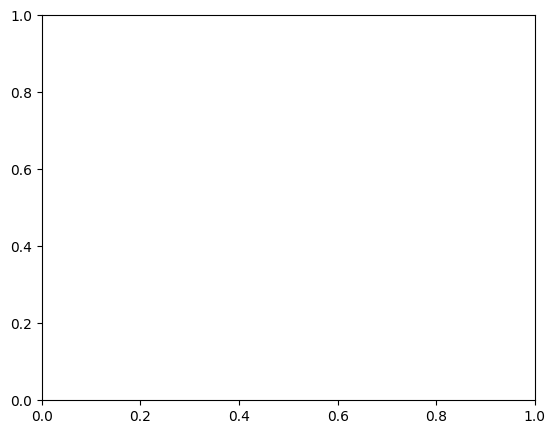

In [33]:
# Plot the complete training history

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Loss curves
plt.subplot(1, 2, 1)
epochs = range(1, len(train_losses_all)+1)
plt.plot(epochs, train_losses_all, 'b-o', label='Train Loss', linewidth=2, markersize=6)
plt.plot(epochs, val_losses_all, 'r-o', label='Val Loss', linewidth=2, markersize=6)
plt.axvline(x=5, color='green', linestyle='--', alpha=0.5, label='Resumed training')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Triplet Loss', fontsize=12)
plt.title('Complete Retriever Training Progress', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Improvement rate
plt.subplot(1, 2, 2)
train_improvement = [train_losses_all[0] - loss for loss in train_losses_all]
val_improvement = [val_losses_all[0] - loss for loss in val_losses_all]
plt.plot(epochs, train_improvement, 'b-o', label='Train Improvement', linewidth=2, markersize=6)
plt.plot(epochs, val_improvement, 'r-o', label='Val Improvement', linewidth=2, markersize=6)
plt.axvline(x=5, color='green', linestyle='--', alpha=0.5)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss Reduction', fontsize=12)
plt.title('Cumulative Improvement', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('retriever_complete_training.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Complete Training Statistics:")
print(f"   Total Epochs:       {len(train_losses_all)}")
print(f"   Initial Train Loss: {train_losses_all[0]:.4f}")
print(f"   Final Train Loss:   {train_losses_all[-1]:.4f}")
print(f"   Initial Val Loss:   {val_losses_all[0]:.4f}")
print(f"   Final Val Loss:     {val_losses_all[-1]:.4f}")
print(f"   Best Val Loss:      {min(val_losses_all):.4f} (Epoch {val_losses_all.index(min(val_losses_all))+1})")
print(f"   Total Improvement:  {((train_losses_all[0] - train_losses_all[-1])/train_losses_all[0]*100):.1f}%")

In [ ]:
# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-o', label='Train Loss', linewidth=2, markersize=8)
plt.plot(range(1, len(val_losses)+1), val_losses, 'r-o', label='Val Loss', linewidth=2, markersize=8)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Triplet Loss', fontsize=12)
plt.title('Retriever Training Progress', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Loss difference
plt.subplot(1, 2, 2)
overfitting = [val - train for train, val in zip(train_losses, val_losses)]
plt.plot(range(1, len(overfitting)+1), overfitting, 'g-o', linewidth=2, markersize=8)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Val Loss - Train Loss', fontsize=12)
plt.title('Overfitting Monitor', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('retriever_training_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Training Statistics:")
print(f"   Initial Train Loss: {train_losses[0]:.4f}")
print(f"   Final Train Loss:   {train_losses[-1]:.4f}")
print(f"   Initial Val Loss:   {val_losses[0]:.4f}")
print(f"   Final Val Loss:     {val_losses[-1]:.4f}")
print(f"   Best Val Loss:      {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses))+1})")
print(f"   Train Improvement:  {((train_losses[0] - train_losses[-1])/train_losses[0]*100):.1f}%")
print(f"   Val Improvement:    {((val_losses[0] - val_losses[-1])/val_losses[0]*100):.1f}%")
print(f"\n✓ Model saved as 'best_retriever_model.pth'")

In [ ]:
# Part 8: LSTM Reader with BiAttention for Answer Extraction

class BiAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(BiAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.W = nn.Linear(hidden_dim * 6, 1, bias=False)
        
    def forward(self, context, query):
        """
        Bi-directional attention between context and query
        Args:
            context: (batch, context_len, hidden_dim)
            query: (batch, query_len, hidden_dim)
        Returns:
            attended_context: (batch, context_len, hidden_dim * 4)
        """
        batch_size, context_len, hidden_dim = context.shape
        query_len = query.shape[1]
        
        # Expand dimensions for broadcasting
        context_expanded = context.unsqueeze(2).expand(-1, -1, query_len, -1)
        # (batch, context_len, query_len, hidden_dim)
        
        query_expanded = query.unsqueeze(1).expand(-1, context_len, -1, -1)
        # (batch, context_len, query_len, hidden_dim)
        
        # Element-wise product
        element_wise = context_expanded * query_expanded
        # (batch, context_len, query_len, hidden_dim)
        
        # Concatenate [context; query; context*query]
        combined = torch.cat([context_expanded, query_expanded, element_wise], dim=-1)
        # (batch, context_len, query_len, hidden_dim * 3)
        
        # Compute similarity scores
        similarity = self.W(combined).squeeze(-1)
        # (batch, context_len, query_len)
        
        # Context-to-query attention
        c2q_attention = F.softmax(similarity, dim=-1)
        # (batch, context_len, query_len)
        
        c2q = torch.bmm(c2q_attention, query)
        # (batch, context_len, hidden_dim)
        
        # Query-to-context attention
        q2c_attention = F.softmax(similarity.max(dim=-1)[0], dim=-1)
        # (batch, context_len)
        
        q2c = torch.bmm(q2c_attention.unsqueeze(1), context)
        # (batch, 1, hidden_dim)
        
        q2c = q2c.expand(-1, context_len, -1)
        # (batch, context_len, hidden_dim)
        
        # Combine: [context; c2q; context*c2q; context*q2c]
        output = torch.cat([context, c2q, context * c2q, context * q2c], dim=-1)
        # (batch, context_len, hidden_dim * 4)
        
        return output


class LSTMReader(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, num_layers=2, dropout=0.3):
        super(LSTMReader, self).__init__()
        
        vocab_size, embedding_dim = embedding_matrix.shape
        self.hidden_dim = hidden_dim
        
        # Embedding layer (shared with retriever or separate)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight = nn.Parameter(embedding_matrix)
        self.embedding.weight.requires_grad = True
        
        # Question encoder
        self.question_lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Context encoder
        self.context_lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Bi-attention
        self.bi_attention = BiAttention(hidden_dim * 2)
        
        # Modeling layer (after attention)
        self.modeling_lstm = nn.LSTM(
            hidden_dim * 8,  # 4 * (hidden_dim * 2) from bi-attention
            hidden_dim,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )
        
        # Output layers for start and end positions
        self.start_output = nn.Linear(hidden_dim * 2, 1)
        self.end_output = nn.Linear(hidden_dim * 2, 1)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, question_ids, question_lengths, context_ids, context_lengths):
        """
        Args:
            question_ids: (batch, question_len)
            question_lengths: (batch,)
            context_ids: (batch, context_len)
            context_lengths: (batch,)
        Returns:
            start_logits: (batch, context_len)
            end_logits: (batch, context_len)
        """
        batch_size = question_ids.shape[0]
        context_len = context_ids.shape[1]
        
        # Embed question and context
        question_embedded = self.embedding(question_ids)
        context_embedded = self.embedding(context_ids)
        
        # Encode question
        packed_question = nn.utils.rnn.pack_padded_sequence(
            question_embedded, question_lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        question_output, _ = self.question_lstm(packed_question)
        question_output, _ = nn.utils.rnn.pad_packed_sequence(question_output, batch_first=True)
        # (batch, question_len, hidden_dim * 2)
        
        # Encode context
        packed_context = nn.utils.rnn.pack_padded_sequence(
            context_embedded, context_lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        context_output, _ = self.context_lstm(packed_context)
        context_output, _ = nn.utils.rnn.pad_packed_sequence(context_output, batch_first=True)
        # (batch, context_len, hidden_dim * 2)
        
        # Bi-attention
        attended = self.bi_attention(context_output, question_output)
        # (batch, context_len, hidden_dim * 8)
        
        # Modeling layer
        modeling_output, _ = self.modeling_lstm(attended)
        # (batch, context_len, hidden_dim * 2)
        
        modeling_output = self.dropout(modeling_output)
        
        # Predict start and end positions
        start_logits = self.start_output(modeling_output).squeeze(-1)
        # (batch, context_len)
        
        end_logits = self.end_output(modeling_output).squeeze(-1)
        # (batch, context_len)
        
        # Mask padding positions
        context_mask = torch.arange(context_len, device=context_ids.device).unsqueeze(0) < context_lengths.unsqueeze(1)
        start_logits = start_logits.masked_fill(~context_mask, -1e9)
        end_logits = end_logits.masked_fill(~context_mask, -1e9)
        
        return start_logits, end_logits

# Initialize reader model
reader_model = LSTMReader(embedding_matrix, hidden_dim=128, num_layers=2).to(device)
print(f"Reader model created")
print(f"Total parameters: {sum(p.numel() for p in reader_model.parameters()):,}")

NameError: name 'nn' is not defined

In [ ]:
# Part 8 (continued): Reader Dataset and Preparation

class ReaderDataset(Dataset):
    def __init__(self, questions, passages, vocab, max_question_len=50, max_context_len=400):
        self.data = []
        self.vocab = vocab
        self.max_question_len = max_question_len
        self.max_context_len = max_context_len
        
        # Prepare training samples
        for q in tqdm(questions, desc="Preparing reader dataset"):
            question = q['question']
            answer = str(q['answer'])
            article_idx = q['article_idx']
            
            # Find passages containing the answer
            for passage in passages:
                if passage['article_idx'] == article_idx:
                    context = passage['text']
                    
                    # Find answer in context
                    answer_start = context.lower().find(answer.lower())
                    
                    if answer_start != -1:
                        # Convert to token positions
                        context_tokens = word_tokenize(context.lower())
                        answer_tokens = word_tokenize(answer.lower())
                        
                        # Find token-level start and end
                        token_start, token_end = self.find_answer_span(
                            context_tokens, answer_tokens
                        )
                        
                        if token_start != -1 and token_end != -1:
                            self.data.append({
                                'question': question,
                                'context': context,
                                'answer_start': token_start,
                                'answer_end': token_end,
                                'context_tokens': context_tokens,
                                'answer_text': answer
                            })
        
        print(f"Created {len(self.data)} reader training samples")
    
    def find_answer_span(self, context_tokens, answer_tokens):
        """Find token-level start and end positions"""
        context_len = len(context_tokens)
        answer_len = len(answer_tokens)
        
        for i in range(context_len - answer_len + 1):
            if context_tokens[i:i+answer_len] == answer_tokens:
                return i, i + answer_len - 1
        
        # Fuzzy matching - find best overlap
        best_start = -1
        best_end = -1
        max_overlap = 0
        
        for i in range(context_len - answer_len + 1):
            overlap = sum(1 for j in range(answer_len) 
                         if i+j < context_len and context_tokens[i+j] == answer_tokens[j])
            if overlap > max_overlap:
                max_overlap = overlap
                best_start = i
                best_end = i + answer_len - 1
        
        if max_overlap > answer_len * 0.5:  # At least 50% match
            return best_start, best_end
        
        return -1, -1
    
    def text_to_indices(self, text, max_len):
        """Convert text to indices"""
        tokens = word_tokenize(text.lower())[:max_len]
        indices = [self.vocab.word2idx.get(token, self.vocab.word2idx['<UNK>']) 
                  for token in tokens]
        return indices, len(indices)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        q_indices, q_len = self.text_to_indices(item['question'], self.max_question_len)
        c_indices, c_len = self.text_to_indices(item['context'], self.max_context_len)
        
        # Adjust answer positions if context was truncated
        answer_start = min(item['answer_start'], c_len - 1)
        answer_end = min(item['answer_end'], c_len - 1)
        
        return {
            'question': q_indices,
            'q_len': q_len,
            'context': c_indices,
            'c_len': c_len,
            'answer_start': answer_start,
            'answer_end': answer_end
        }

def reader_collate_fn(batch):
    """Collate function for reader dataloader"""
    questions = [item['question'] for item in batch]
    contexts = [item['context'] for item in batch]
    
    q_lens = torch.LongTensor([item['q_len'] for item in batch])
    c_lens = torch.LongTensor([item['c_len'] for item in batch])
    answer_starts = torch.LongTensor([item['answer_start'] for item in batch])
    answer_ends = torch.LongTensor([item['answer_end'] for item in batch])
    
    # Pad sequences
    max_q_len = max(len(q) for q in questions)
    max_c_len = max(len(c) for c in contexts)
    
    q_padded = torch.zeros(len(batch), max_q_len, dtype=torch.long)
    c_padded = torch.zeros(len(batch), max_c_len, dtype=torch.long)
    
    for i, (q, c) in enumerate(zip(questions, contexts)):
        q_padded[i, :len(q)] = torch.LongTensor(q)
        c_padded[i, :len(c)] = torch.LongTensor(c)
    
    return {
        'question': q_padded,
        'q_len': q_lens,
        'context': c_padded,
        'c_len': c_lens,
        'answer_start': answer_starts,
        'answer_end': answer_ends
    }

# Create reader dataset
reader_train_dataset = ReaderDataset(train_questions, passages, vocab)
reader_val_dataset = ReaderDataset(val_questions, passages, vocab)

reader_train_loader = DataLoader(
    reader_train_dataset, batch_size=16, shuffle=True, collate_fn=reader_collate_fn
)
reader_val_loader = DataLoader(
    reader_val_dataset, batch_size=16, shuffle=False, collate_fn=reader_collate_fn
)

print(f"Reader train dataset: {len(reader_train_dataset)} samples")
print(f"Reader val dataset: {len(reader_val_dataset)} samples")

NameError: name 'Dataset' is not defined

In [ ]:
# Part 10: Complete Q&A Inference Pipeline
import torch
import torch.nn.functional as F
from nltk.tokenize import word_tokenize
import numpy as np
from collections import defaultdict

device = torch.device('cpu')

class NewsQASystem:
    def __init__(self, retriever_model, reader_model, vocab, passages, 
                 retriever_path='best_retriever_model.pth', 
                 reader_path='best_reader_model.pth',
                 confidence_threshold=0.3):
        """
        Complete Q&A system for news articles
        
        Args:
            retriever_model: Trained BiLSTM retriever
            reader_model: Trained LSTM reader
            vocab: Vocabulary object
            passages: List of passage dictionaries
            retriever_path: Path to saved retriever model
            reader_path: Path to saved reader model
            confidence_threshold: Minimum confidence to return an answer
        """
        self.retriever = retriever_model.to(device)
        self.reader = reader_model.to(device)
        self.vocab = vocab
        self.passages = passages
        self.confidence_threshold = confidence_threshold
        
        # Load trained models
        print("Loading trained models...")
        retriever_checkpoint = torch.load(retriever_path, map_location=device)
        self.retriever.load_state_dict(retriever_checkpoint['model_state_dict'])
        self.retriever.eval()
        
        reader_checkpoint = torch.load(reader_path, map_location=device)
        self.reader.load_state_dict(reader_checkpoint['model_state_dict'])
        self.reader.eval()
        
        print("✓ Models loaded successfully!")
        
        # Encode all passages for retrieval
        print("Encoding passages for retrieval...")
        self.passage_embeddings = self._encode_all_passages()
        print(f"✓ Encoded {len(self.passage_embeddings)} passages")
    
    def _text_to_indices(self, text, max_len=100):
        """Convert text to word indices"""
        tokens = word_tokenize(text.lower())[:max_len]
        indices = [self.vocab.word2idx.get(token, self.vocab.word2idx['<UNK>']) 
                  for token in tokens]
        length = len(indices)
        return indices, length, tokens
    
    def _encode_all_passages(self):
        """Encode all passages using the retriever"""
        embeddings = []
        
        with torch.no_grad():
            for passage in tqdm(self.passages, desc="Encoding passages"):
                indices, length, _ = self._text_to_indices(passage['text'], max_len=400)
                
                # Convert to tensors
                ids = torch.LongTensor([indices]).to(device)
                lens = torch.LongTensor([length]).to(device)
                
                # Encode
                embedding = self.retriever(ids, lens)
                embeddings.append(embedding.cpu().numpy())
        
        return np.vstack(embeddings)
    
    def retrieve_passages(self, question, top_k=20):
        """
        Retrieve top-k relevant passages for a question
        
        Args:
            question: Question string
            top_k: Number of passages to retrieve
            
        Returns:
            List of (passage_dict, score) tuples
        """
        # Encode question
        indices, length, _ = self._text_to_indices(question, max_len=50)
        q_ids = torch.LongTensor([indices]).to(device)
        q_lens = torch.LongTensor([length]).to(device)
        
        with torch.no_grad():
            q_embedding = self.retriever(q_ids, q_lens).cpu().numpy()
        
        # Compute similarities (cosine similarity)
        similarities = np.dot(self.passage_embeddings, q_embedding.T).flatten()
        
        # Get top-k indices
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        # Return passages with scores
        results = []
        for idx in top_indices:
            results.append({
                'passage': self.passages[idx],
                'score': float(similarities[idx]),
                'passage_idx': int(idx)
            })
        
        return results
    
    def extract_answer(self, question, passage_text):
        """
        Extract answer from a passage using the reader
        
        Args:
            question: Question string
            passage_text: Passage text
            
        Returns:
            Dictionary with answer, confidence, start, end positions
        """
        # Tokenize
        q_indices, q_len, q_tokens = self._text_to_indices(question, max_len=50)
        c_indices, c_len, c_tokens = self._text_to_indices(passage_text, max_len=400)
        
        # Convert to tensors
        q_ids = torch.LongTensor([q_indices]).to(device)
        q_lens = torch.LongTensor([q_len]).to(device)
        c_ids = torch.LongTensor([c_indices]).to(device)
        c_lens = torch.LongTensor([c_len]).to(device)
        
        with torch.no_grad():
            start_logits, end_logits = self.reader(q_ids, q_lens, c_ids, c_lens)
            
            # Get probabilities
            start_probs = F.softmax(start_logits, dim=1)[0]
            end_probs = F.softmax(end_logits, dim=1)[0]
            
            # Get best positions
            start_idx = start_probs.argmax().item()
            end_idx = end_probs.argmax().item()
            
            # Ensure end >= start
            if end_idx < start_idx:
                end_idx = start_idx
            
            # Get confidence (product of probabilities)
            confidence = (start_probs[start_idx] * end_probs[end_idx]).item()
            
            # Extract answer text
            if start_idx < len(c_tokens) and end_idx < len(c_tokens):
                answer_tokens = c_tokens[start_idx:end_idx+1]
                answer_text = ' '.join(answer_tokens)
            else:
                answer_text = ""
            
            return {
                'answer': answer_text,
                'confidence': confidence,
                'start': start_idx,
                'end': end_idx,
                'start_prob': start_probs[start_idx].item(),
                'end_prob': end_probs[end_idx].item()
            }
    
    def answer_question(self, question, top_k=20, top_m=5, verbose=True):
        """
        Complete pipeline: retrieve passages and extract answer
        
        Args:
            question: Question string
            top_k: Number of passages to retrieve
            top_m: Number of passages to read
            verbose: Print detailed output
            
        Returns:
            Dictionary with answer, confidence, citations
        """
        if verbose:
            print(f"\n{'='*70}")
            print(f"Question: {question}")
            print(f"{'='*70}")
        
        # Step 1: Retrieve passages
        retrieved = self.retrieve_passages(question, top_k=top_k)
        
        if verbose:
            print(f"\n📥 Retrieved {len(retrieved)} passages")
        
        # Step 2: Re-rank and select top-m
        top_passages = retrieved[:top_m]
        
        # Step 3: Extract answers from top passages
        candidates = []
        
        for i, result in enumerate(top_passages):
            passage = result['passage']
            retrieval_score = result['score']
            
            # Extract answer
            answer_result = self.extract_answer(question, passage['text'])
            
            if answer_result['answer']:
                candidates.append({
                    'answer': answer_result['answer'],
                    'confidence': answer_result['confidence'],
                    'retrieval_score': retrieval_score,
                    'combined_score': answer_result['confidence'] * retrieval_score,
                    'passage': passage,
                    'title': passage['title'],
                    'timestamp': passage['timestamp'],
                    'article_idx': passage['article_idx']
                })
        
        if not candidates:
            if verbose:
                print("\n❌ No answer found")
                print("\nTop sources:")
                for i, result in enumerate(retrieved[:3]):
                    p = result['passage']
                    print(f"\n{i+1}. {p['title']}")
                    print(f"   Date: {p['timestamp']}")
                    print(f"   Score: {result['score']:.3f}")
            
            return {
                'answer': 'NOT FOUND',
                'confidence': 0.0,
                'citations': [r['passage'] for r in retrieved[:3]]
            }
        
        # Step 4: Select best answer
        best_candidate = max(candidates, key=lambda x: x['combined_score'])
        
        if best_candidate['confidence'] < self.confidence_threshold:
            if verbose:
                print(f"\n⚠️  Low confidence ({best_candidate['confidence']:.3f} < {self.confidence_threshold})")
                print(f"\nBest attempt: {best_candidate['answer']}")
                print("\nTop sources:")
                for i, result in enumerate(retrieved[:3]):
                    p = result['passage']
                    print(f"\n{i+1}. {p['title']}")
                    print(f"   Date: {p['timestamp']}")
            
            return {
                'answer': 'NOT FOUND',
                'confidence': best_candidate['confidence'],
                'best_attempt': best_candidate['answer'],
                'citations': [r['passage'] for r in retrieved[:3]]
            }
        
        # Step 5: Return answer with citations
        if verbose:
            print(f"\n✅ Answer found with confidence {best_candidate['confidence']:.3f}")
            print(f"\n📝 Answer: {best_candidate['answer']}")
            print(f"\n📰 Citation:")
            print(f"   Title: {best_candidate['title']}")
            print(f"   Date: {best_candidate['timestamp']}")
            print(f"   Retrieval Score: {best_candidate['retrieval_score']:.3f}")
            print(f"   Extraction Confidence: {best_candidate['confidence']:.3f}")
            
            if len(candidates) > 1:
                print(f"\n📚 Alternative answers from other sources:")
                for i, cand in enumerate(candidates[1:4], 1):
                    print(f"\n   {i}. {cand['answer']}")
                    print(f"      From: {cand['title'][:60]}...")
                    print(f"      Confidence: {cand['confidence']:.3f}")
        
        return {
            'answer': best_candidate['answer'],
            'confidence': best_candidate['confidence'],
            'title': best_candidate['title'],
            'timestamp': best_candidate['timestamp'],
            'article_idx': best_candidate['article_idx'],
            'retrieval_score': best_candidate['retrieval_score'],
            'all_candidates': candidates,
            'top_sources': [r['passage'] for r in retrieved[:5]]
        }


# Initialize the Q&A System
print("\n" + "="*70)
print("Initializing News Q&A System")
print("="*70)

qa_system = NewsQASystem(
    retriever_model=retriever_model,
    reader_model=reader_model,
    vocab=vocab,
    passages=passages,
    retriever_path='best_retriever_model.pth',
    reader_path='best_reader_model.pth',
    confidence_threshold=0.3
)

print("\n✓ Q&A System ready!")


Initializing News Q&A System


NameError: name 'retriever_model' is not defined